In [ ]:
!apt update && apt install xvfb
!pip install gym-notebook-wrapper
!apt update && apt install python-opengl ffmpeg
!pip install ufal.pybox2d
!pip install shimmy

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [53.5 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [917 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,885 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [51.5 kB]
Get:13

# 실습 게임 정보

https://gymnasium.farama.org/environments/box2d/lunar_lander/

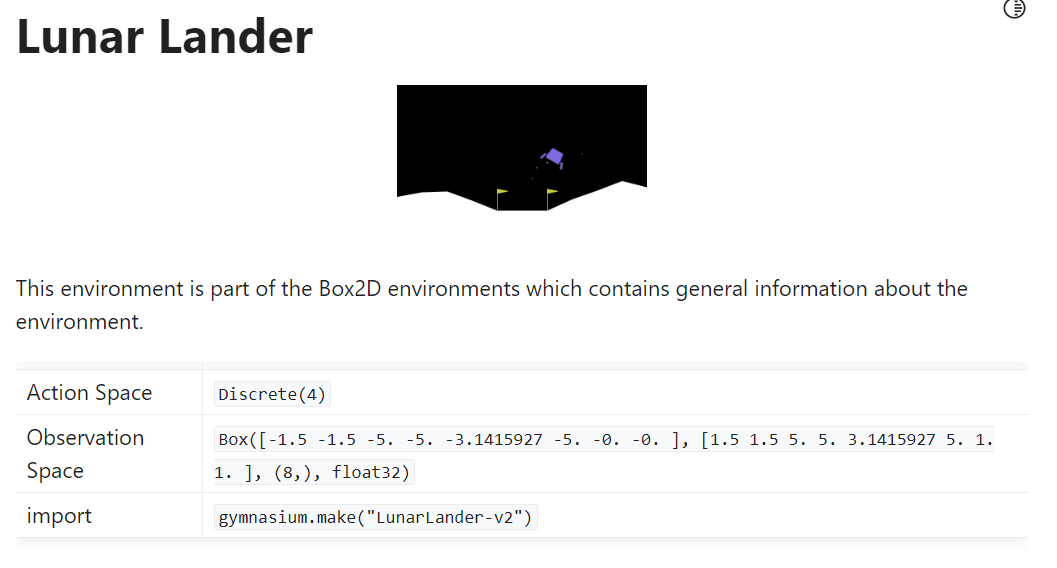

# 코드 설명

In [ ]:
# 코드 출처: https://github.com/seungeunrho/minimalRL

import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

class PPO(nn.Module):
    def __init__(self):
        super(PPO, self).__init__()
        self.data = []

        self.fc1   = nn.Linear(?,256) # ? 에 들어갈 숫자는?
        self.fc_pi = nn.Linear(256, ?) # ? 에 들어갈 숫자는?
        self.fc_value  = nn.Linear(256, ?) # ? 에 들어갈 숫자는?
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    # 상태를 입력 받고, 각 행동 별 확률을 리턴
    def pi(self, x, softmax_dim = 0):
        x = F.relu(self.fc1(x))
        x = self.fc_pi(x)
        prob = F.softmax(x, dim=softmax_dim)
        return prob

    # 상태를 입력 받고, 그 상태에 대한 미래 가치를 리턴
    def value(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc_value(x)
        return v

    def put_data(self, transition):
        self.data.append(transition)

    # 학습을 위한 History를 만드는 부분
    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []
        for transition in self.data:
            s, a, r, s_prime, prob_a, done = transition

            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            prob_a_lst.append([prob_a])
            done_mask = 0 if done else 1
            done_lst.append([done_mask])

        s,a,r,s_prime,done_mask, prob_a = torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
                                          torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
                                          torch.tensor(done_lst, dtype=torch.float), torch.tensor(prob_a_lst)
        self.data = []
        return s, a, r, s_prime, done_mask, prob_a

    # 모여진 히스토리로 모델의 Weight를 업데이트 하는 과정
    def train_net(self):
        s, a, r, s_prime, done_mask, prob_a = self.make_batch() # 모여진 데이터를 배치 형태로 만듦

        for i in range(K_epoch): # 같은 데이터로 K번 업데이트 합니다.

            # 각 스텝 별 Advantage를 구합니다
            td_target = r + gamma * self.value(s_prime) * done_mask
            delta = td_target - self.value(s)
            delta = delta.detach().numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])

            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float)

            # Old Policy와 New Policy 간의 Ratio를 구합니다.
            # Old_policy = prob_a, New Policy = pi_a
            pi = self.pi(s, softmax_dim=1)
            pi_a = pi.gather(1, a)
            ratio = torch.exp(torch.log(pi_a) - torch.log(prob_a))  # a/b == exp(log(a)-log(b))

            # Advantage와 td_error를 기반으로 loss를 구합니다.
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
            loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.value(s) , td_target.detach())

            # weight update
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

In [ ]:
#Hyperparameters
learning_rate = 0.0005
gamma         = 0.98
lmbda         = 0.95
eps_clip      = 0.1
K_epoch       = 3
T_horizon     = 20

In [ ]:
model = PPO()
score = 0.0
print_interval = 20

In [ ]:
import gnwrapper
import gym
import warnings
warnings.filterwarnings('ignore')

env = gnwrapper.Monitor(gym.make('LunarLander-v2'),directory="./", video_callable=lambda episode_id: episode_id%100==0) # Start Xvfb

for n_epi in range(500):
    s = env.reset()
    done = False
    while not done:
        for t in range(T_horizon):# 몇 번의 Step까지 실행한 뒤 학습 할 것인가?

            prob = model.pi(torch.from_numpy(s).float()) # 현재 상태를 입력으로 넣고 각 행동에 대한 확률을 출력
            m = Categorical(prob)
            a = m.sample().item() # 각 행동에 대한 확률을 기반으로 한 가지 Action을 선택
            s_prime, r, done, info = env.step(a) # 실제 Action을 실행하고, 그에 따른 Reward 및 다음 상태를 리턴 받음.

            model.put_data((s, a, r, s_prime, prob[a].item(), done)) # 데이터 저장
            s = s_prime

            score += r
            if done: # 게임 오버가 됐으면 break
                env.reset()
                break

        model.train_net() # 모여진 데이터로 model weight update

    if n_epi%print_interval==0 and n_epi!=0:
        print("# of episode :{}, avg score : {:.1f}".format(n_epi, score/print_interval))
        score = 0.0

# of episode :20, avg score : -220.1
# of episode :40, avg score : -236.6
# of episode :60, avg score : -429.9
# of episode :80, avg score : -507.9
# of episode :100, avg score : -258.4
# of episode :120, avg score : -150.3
# of episode :140, avg score : -132.0
# of episode :160, avg score : -202.3
# of episode :180, avg score : -208.0
# of episode :200, avg score : -229.6
# of episode :220, avg score : -237.9
# of episode :240, avg score : -211.8
# of episode :260, avg score : -197.2
# of episode :280, avg score : -100.4
# of episode :300, avg score : -127.6
# of episode :320, avg score : -92.9
# of episode :340, avg score : -130.4
# of episode :360, avg score : -152.7
# of episode :380, avg score : -45.0
# of episode :400, avg score : -73.3
# of episode :420, avg score : -28.9
# of episode :440, avg score : -45.3
# of episode :460, avg score : -59.7
# of episode :480, avg score : -77.8


In [ ]:
env.display() # Here, display saved display images as movies

'rl-video-episode-0.mp4'

'rl-video-episode-100.mp4'

'rl-video-episode-100.mp4'

'rl-video-episode-100.mp4'

'rl-video-episode-200.mp4'

'rl-video-episode-200.mp4'

'rl-video-episode-200.mp4'

'rl-video-episode-300.mp4'

'rl-video-episode-300.mp4'

'rl-video-episode-300.mp4'

'rl-video-episode-400.mp4'

'rl-video-episode-400.mp4'

'rl-video-episode-400.mp4'

'rl-video-episode-500.mp4'

'rl-video-episode-500.mp4'